# Hand Digit Recognition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from skimage import io, transform
from PIL import Image as im
import cv2, time, sys, os

from sklearn import datasets, svm, metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import keras
from keras import models
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image as kerasimage

### Load dataset and labels

In [2]:
# Loading the images with dimension (1, 64, 64, 3) using cv2 
# returns images and label as nparray
def load_data(folder):
    images = [] 
    labels = [] 
    # Obtain all images and their labels from the directory
    for filename in os.listdir(folder):
        read_img = cv2.imread(os.path.join(folder, filename))
        if read_img is not None:
            # Only taking left hand images
            if filename[-5] == 'L':
                # Resizing 128x128x3 pixel original image into 64x64x3 
                read_img = cv2.resize(read_img, (64,64))
                ## img_binary = cv2.threshold(read_img, 70, 255, cv2.THRESH_BINARY)[1]
                ## images.append(img_binary)
                images.append(read_img)
                labels.append(filename[-6]) # Get the label
    images =  np.asarray(images)
    labels = np.asarray(labels)
    return images, labels

In [3]:
# display a single image using imshow
def display_image(img):
    plt.figure()
    plt.imshow(img) 
    plt.show()  

### Brief dataset description
Dataset contains total of 21,600 images <br>
- Training set: 18000 images <br>
- Testing set: 3600 images <br>

### Label
Labels are in two last characters of filename <br>
- L/R indicates left/right hand <br>
- 0,1,2,3,4,5 indicates number of fingers <br>
- With 0-5 digits and L/R hand, there are 12 total classes 

In [4]:
# Load the path of the image directory for test and train set
# Obtain dataset with their labels
X_train, Y_train = load_data('./data/train/')
X_test, Y_test = load_data('./data/test/')

# Show the shape of training and testing set along with their label
print("X training dataset: ", X_train.shape)
print("Y training dataset: ", Y_train.shape)
print("X testing dataset: ", X_test.shape)
print("Y testing dataset: ", Y_test.shape)

X training dataset:  (9000, 64, 64, 3)
Y training dataset:  (9000,)
X testing dataset:  (1800, 64, 64, 3)
Y testing dataset:  (1800,)


### Display image from training dataset

Label:  2


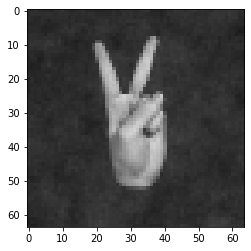

In [5]:
# Displaying one random training image with its label
print('Label: ', Y_train[552])
display_image(X_train[552])

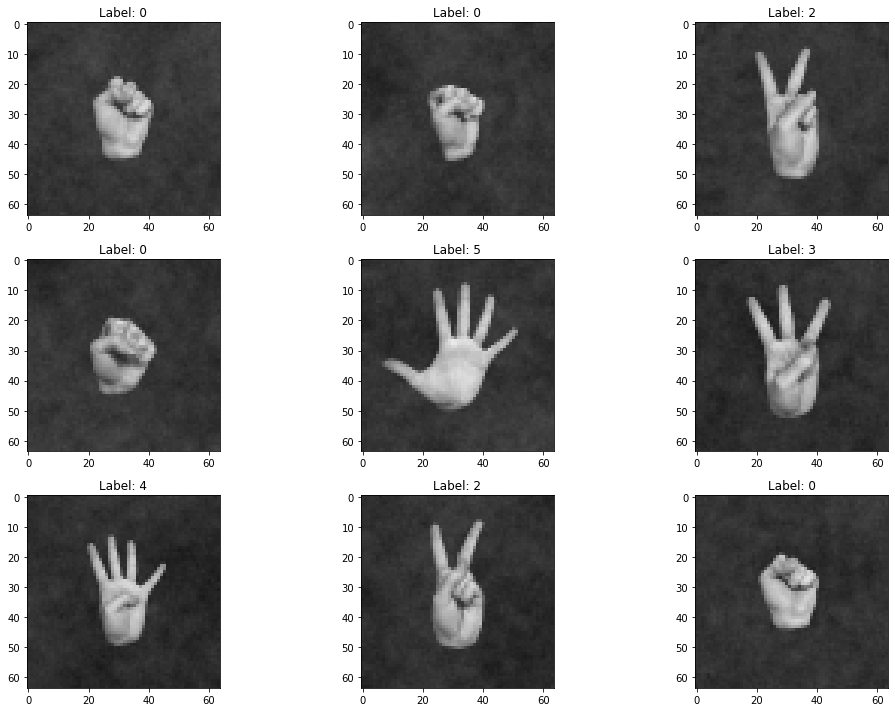

In [6]:
# list of classes. 0-5 finger digits
list_of_classes = ['0', '1', '2', '3', '4', '5']
num_classes = len(list_of_classes)

# Display images of the training dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Label: {Y_train[i]}")
plt.tight_layout()
plt.show()

In [7]:
# Convert the labels from just an integer into a categorical vector with 1 
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test  = np_utils.to_categorical(Y_test, num_classes)

# Convert all datatype into float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the images dividing by 255
X_train /= 255
X_test /= 255

### Creating a CNN model

In [8]:
# Ceating a simple CNN using Keras
def define_model(train_shape, num_of_classes):
    model = Sequential()

    # 3x3 convolution layer with 2x2 stride and 32 filters
    model.add(Conv2D(32, (3, 3), strides = (2,2), padding='same',
                    input_shape = train_shape))
    model.add(Activation('relu'))
    
    # 3x3 convolution layer with 1x1 stride and 64 filters
    model.add(Conv2D(64, (3, 3), strides = (1,1)))
    model.add(Activation('relu'))

    # 2x2 Max-pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Faltten into one-dimensional vector and two fully connected dense layers
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_of_classes))
    model.add(Activation('softmax'))

    return model

In [9]:
# Create a CNN model and show its summary
model_1 = define_model(X_train.shape[1:], num_classes)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

### Train the model

In [10]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005, decay=1e-6)

# Train the model with categroical_crossentropy loss function and RMSprop optimizer
model_1.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

# fit the model with 5 epochs
history = model_1.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=5,
            validation_data=(X_test, Y_test),
            shuffle=True)

Epoch 1/5
282/282 [==============================] - 11s 37ms/step - loss: 0.8444 - accuracy: 0.6844 - val_loss: 0.0441 - val_accuracy: 0.9850
Epoch 2/5
282/282 [==============================] - 9s 34ms/step - loss: 0.1246 - accuracy: 0.9503 - val_loss: 0.0257 - val_accuracy: 0.9917
Epoch 3/5
282/282 [==============================] - 9s 33ms/step - loss: 0.0810 - accuracy: 0.9676 - val_loss: 0.0087 - val_accuracy: 0.9956
Epoch 4/5
282/282 [==============================] - 9s 33ms/step - loss: 0.0501 - accuracy: 0.9802 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/5
282/282 [==============================] - 9s 33ms/step - loss: 0.0401 - accuracy: 0.9820 - val_loss: 0.0027 - val_accuracy: 0.9994


In [19]:
# Save the model
model_1.save('model_1.h5')

### Plotting accuracy & loss

In [11]:
# plot the accuracy of model
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
#     plt.savefig('Accuracy.png')

# plot the loss of model
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
#     plt.savefig('Loss.png')

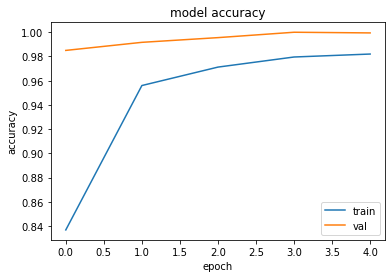

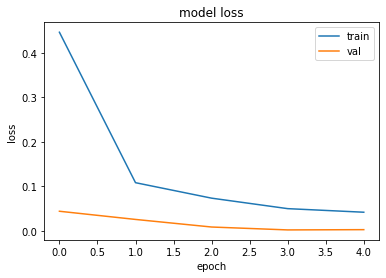

In [12]:
plot_accuracy(history)
plot_loss(history)

### Evaluation & Prediction

In [20]:
model_1 = models.load_model('model_1.h5')
list_of_classes = ['0', '1', '2', '3', '4', '5']

In [14]:
score = model_1.evaluate(X_test, Y_test)

57/57 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9994


In [15]:
prediction = model_1.predict(X_test)

### Confusion Matrix

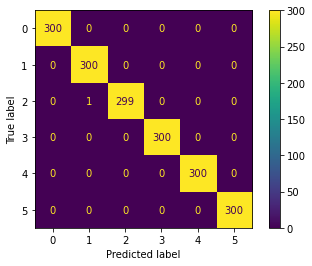

In [16]:
y_true = np.argmax(Y_test, axis=1)     
y_pred = np.argmax(prediction, axis=1)

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=list_of_classes)
cmd.plot()

### Classification Report

In [17]:
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       300
           1      0.997     1.000     0.998       300
           2      1.000     0.997     0.998       300
           3      1.000     1.000     1.000       300
           4      1.000     1.000     1.000       300
           5      1.000     1.000     1.000       300

    accuracy                          0.999      1800
   macro avg      0.999     0.999     0.999      1800
weighted avg      0.999     0.999     0.999      1800



### Making final prediction

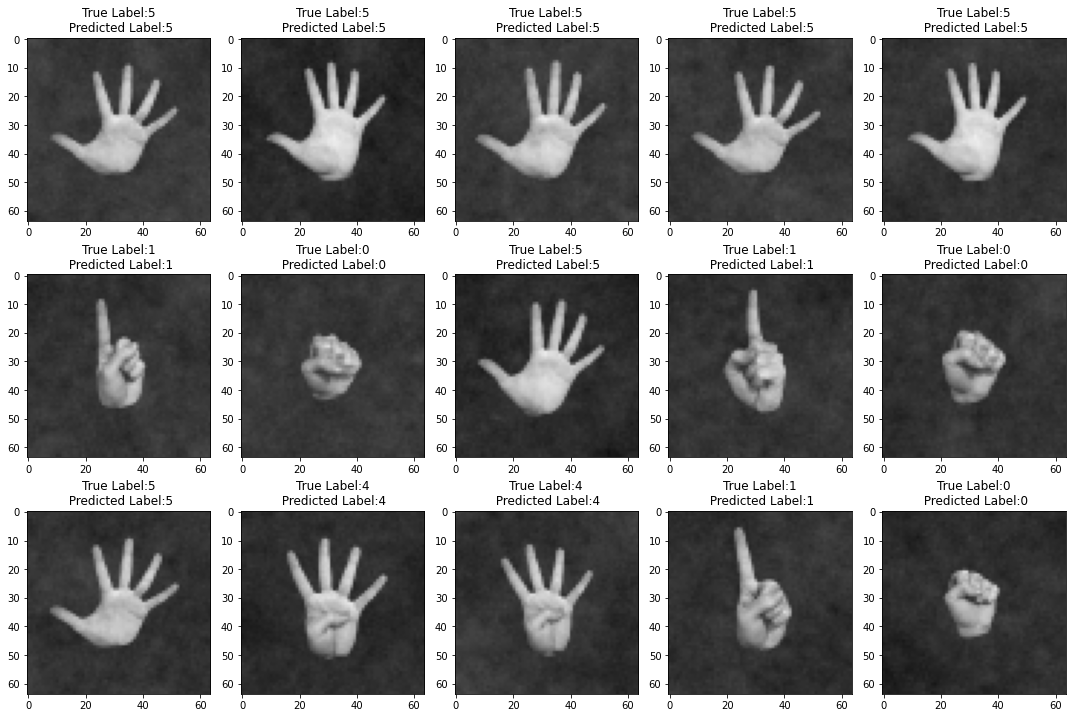

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_title(f"True Label:{list_of_classes[np.argmax(Y_test[i])]}\n Predicted Label:{list_of_classes[np.argmax(prediction[i])]}")

plt.tight_layout()
plt.show()

In [ ]:
# datagen = ImageDataGenerator(
#         rotation_range=20,
#         zoom_range=0.2,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.12, 
#         rescale=1./255)

# # test_datagen = ImageDataGenerator(rescale=1./255)

# training_set = datagen.flow(X_train, Y_train)
# # validation_set = datagen.flow(X_test, Y_test)

# # history = model_1.fit(training_set,
# ##                       steps_per_epoch=len(training_set),
# #                       epochs = 10,
# #                       validation_data=validation_set,
# ##                       validation_steps = len(validation_set),
# #                       shuffle=True)

### Making Real-time Prediction

In [6]:
# model_1 = models.load_model('model_1.h5')
# list_of_classes = ['0', '1', '2', '3', '4', '5']

# camera = cv2.VideoCapture(0)

# fgbg = cv2.createBackgroundSubtractorMOG2()
    
# while 1:
#     ret, frame = camera.read()
#     frame = cv2.flip(frame, 1)
    
#     top, right, bottom, left = 75, 350, 300, 590
#     roi = frame[top:bottom, right:left]
#     roi = cv2.flip(roi,1)
    
#     roi = fgbg.apply(roi)
    
#     # gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#     gray = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
#     gray = cv2.GaussianBlur(gray, (5, 5), 0)
#     cv2.imshow('roi', gray)

#     myimage = np.asarray(gray)
#     myimage = cv2.resize(myimage, (64, 64))
#     myimage = kerasimage.img_to_array(myimage, dtype='float32')
#     # myimage = cv2.threshold(myimage, 0, 255, cv2.THRESH_BINARY)[1]
#     myimage /= 255 
#     myimage = np.expand_dims(myimage, axis=0)
#     pred_list = model_1.predict(myimage)
#     # print(pred_list)
#     result = list_of_classes[np.argmax(pred_list)]
    
#     cv2.rectangle(frame, (left, top), (right, bottom), (0,255,0), 2)
#     cv2.putText(frame, str(result),(0,130),cv2.FONT_HERSHEY_SIMPLEX,5,(0,0,255),2)
#     cv2.imshow('Frame', frame)
    
#     # Press 'q' or 'esc' key to exit
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('q'):
#         break
        
#     if cv2.waitKey(1) == 27:
#         break 
        
# camera.release()
# cv2.destroyAllWindows()